# HW2: Local Planning

### EECE 5550: Mobile Robotics (Spring 2024)


**Collaboration Statement:**

In [1]:
#I took guidance from Rahil Bhowal for question 1a.

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [2]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to c:\users\anuj\appdata\local\temp\pip-req-build-825fvk2l
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit accce6e955894ab920542ee00ef52e28a02b79ef
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git 'C:\Users\Anuj\AppData\Local\Temp\pip-req-build-825fvk2l'


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [1]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
from typing import List
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

# Problem 1: MPPI

## 1a) MPPI to move toward a goal coordinate

In this problem, you'll implement a basic version of MPPI and show that it outputs a good rollout to move a robot toward a given goal position. This part uses the Unicycle kinematic model that's built into the simulator. You should  make sure that your `get_action` method considers the control limits (otherwise it may command things that the robot can't execute), which may require passing those as arguments to the `__init__` method.

You will probably need to experiment with different numbers of rollouts, cost functions, λ values, numbers of iterations, etc. to get good performance.

Keeping this code relatively organized and clean will help for later parts in the assignment, where you build on this implementation. For example, you are encouraged to define helper methods in your `MPPI` class to help keep your code organized (e.g., you may want a `score_rollouts` and/or `plot_rollouts` method that get called inside the `get_next_action` method).

**Deliverables**:
- Implement the `MPPI` class, in particular the `get_next_action` method, so that the chosen rollout drives the robot toward the goal position.
- Print the best control sequence your MPPI algorithm came up with (the first row/element of this sequence should be the action that your `get_action` returns)
- Include a plot that shows the rollouts, start position, goal position, and highlights the best rollout in that iteration, for at least a few iterations. We expect that the later iterations will give much better rollouts than the first iteration. You should make your axes have the same scale (e.g., using `plt.axis('equal')`).

In [8]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [9]:
class MPPI:
    def __init__(
        self,
        motion_model=motion_models.Unicycle(),
        num_rollouts=10, 
        num_iterations=20,
    	sigma=1,
    	horizon=10, 
        lambda_=1.0,

    ):
        """ Your implementation here """
        self.motion_model = motion_model
        self.action_space = spaces.Box(np.array([0, -2*np.pi]),
                                       np.array([1, 2*np.pi]),
                                       shape=(2,),
                                       dtype=float)
        self.num_rollouts = 100
        self.num_iterations = num_iterations
        self.lambda_ = lambda_

    def update_state(self, state, action, dt):
        x, y, theta = state
        v, omega = action

        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta += omega * dt

        theta = (theta + 2 * np.pi) % (2 * np.pi)

        return np.array([x, y, theta])


    def compute_scores(self, rollouts, goal_pos):
        scores = np.zeros(self.num_rollouts)

        for i, (_, trajectory, _) in enumerate(rollouts):
            final_pos = trajectory[-1][:2]
            scores[i] = -np.linalg.norm(goal_pos - final_pos)

        return scores

    def get_action(self, initial_state, goal_pos):
        best_rollout = None
        best_rollouts = []
        best_best_rollouts = []

        for iteration in range(self.num_iterations):
            rollouts = []

            for _ in range(self.num_rollouts):
                random_action = np.random.uniform(low=self.motion_model.action_space.low,
                                                   high=self.motion_model.action_space.high)

                trajectory = self.generate_trajectory(initial_state, random_action)
                cost = self.compute_cost(trajectory, goal_pos)

                rollouts.append((random_action, trajectory, cost))

            scores = self.compute_scores(rollouts, goal_pos)
            best_rollout = rollouts[np.argmax(scores)]
            best_action = best_rollout[0]
            best_rollouts.append(best_rollout)

        print(len(best_rollouts))
        best_scores = self.compute_scores(best_rollouts, goal_pos)
        non_zero_indices = np.nonzero(best_scores)
        best_scores = best_scores[non_zero_indices]
        print(best_scores)
        print(max(best_scores))
        max_index = np.argmax(best_scores)
        print(max_index)
        best_best_rollout = best_rollouts[np.argmax(best_scores)]
        best_best_action = best_best_rollout[0]

        self.plot_rollouts(best_rollouts, initial_state, goal_pos, best_best_rollout)

        return best_best_action

    def generate_trajectory(self, initial_state, action, dt=0.1, steps=10):
        trajectory = [initial_state]

        for _ in range(steps):
            next_state = self.update_state(initial_state, action, dt)
            initial_state = next_state
            trajectory.append(next_state)

        return np.array(trajectory)

    def compute_cost(self, trajectory, goal_pos):
        final_pos = trajectory[-1][:2]
        return -np.linalg.norm(goal_pos-final_pos)

    def plot_rollouts(self, rollouts, start_pos, goal_pos, best_rollout):
        plt.figure()
        plt.title("MPPI Rollouts")
        plt.scatter(start_pos[0], start_pos[1], color='green', marker='o', label='Initial Position')
        plt.scatter(goal_pos[0], goal_pos[1], color='yellow', marker='x', label='Goal Position')

        for _, trajectory, _ in rollouts:
            plt.plot(trajectory[:, 0], trajectory[:, 1], color='black', alpha=0.1)

        best_trajectory = best_rollout[1]
        final_pos = best_trajectory[-1][:2]
        final_dis = np.linalg.norm(goal_pos-final_pos)
        plt.plot(best_trajectory[:, 0], best_trajectory[:, 1], color='blue', label='Best Rollout of Robot')

        plt.legend()
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

You can use the following code to check whether your MPPI implementation is working. After tuning your algorithm, it should be able to come up with a rollout that ends close to the goal (within 0.1m in l2 distance is close enough):

20
[-0.15531842 -0.03449361 -0.10995393 -0.07163167 -0.18705172 -0.06388157
 -0.08641456 -0.05993842 -0.04950998 -0.11521617 -0.12884251 -0.04947163
 -0.21628014 -0.09700209 -0.11784017 -0.09447443 -0.07897771 -0.0315758
 -0.03317722 -0.13182009]
-0.03157579563049457
17


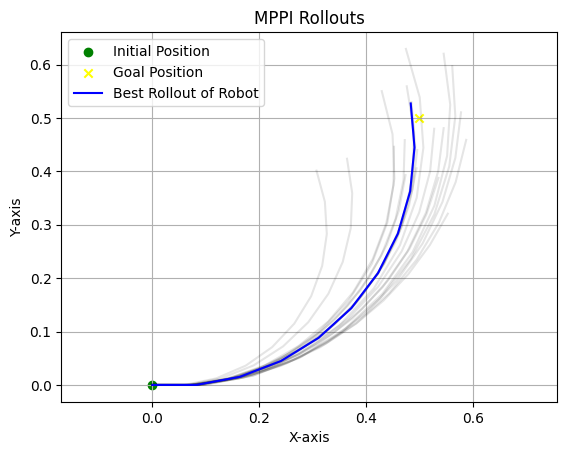

In [10]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)
obs, _ = env.reset()

# Set the starting state (x, y, theta) and goal position (x, y).
initial_state = np.array([0.0, 0.0, 0.0])
goal_pos = np.array([0.5, 0.5])

# Instantiate your contoller class
controller = MPPI()

# Run your control algorithm for 1 step. We'll worry about running your
# algorithm in closed-loop in later parts of the assignment.
action = controller.get_action(initial_state, goal_pos)

## 1b) MPPI to drive around a racetrack

Now you will extend your MPPI implementation so that your robot drives around a racetrack. There are a few interesting challenges you'll need to figure out that didn't appear in the earlier problem:

*   How to score rollouts? Some possible ideas include placing waypoints around the track, designing a cost-to-go function, or encouraging the vehicle to maintain full speed, but this is completely up to you!
*   How to ensure the robot doesn't collide with the walls? 
**Deliverables**:
- Implement the `MPPIRacetrack` class below to enable your robot to complete a full lap around the track
- Generate a plot of the path taken with some indication of time (e.g., using a colorbar, timestamps every so often along the path, or another creative way you come up with)

In [11]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [12]:
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        num_rollouts=100,
        horizon=10,
        lambda_=1.0,
        sigma=0.1,
        control_limits=(-1.0, 1.0),
        map_resolution=0.05  # Specify the map resolution
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.num_rollouts = num_rollouts
        self.horizon = horizon
        self.lambda_ = lambda_
        self.sigma = sigma
        self.control_limits = control_limits
        self.map_resolution = map_resolution

    def get_action(self, initial_state: np.array) -> np.array:
        best_action = np.zeros_like(self.motion_model.action_space.sample())
        best_score = float('-inf')
        best_rollout = []

        # Initialize list to store all rollouts for plotting
        all_rollouts = []

        # Generate control sequences and simulate rollouts
        for _ in range(self.num_rollouts):
            action = self.motion_model.action_space.sample()  # Sample initial action
            rollout = []  # List to store trajectory for this rollout
            state = initial_state.copy()  # Initialize state

            # Simulate trajectory for the fixed horizon
            for _ in range(self.horizon):
                action += np.random.normal(0, self.sigma, action.shape)  # Add noise to action
                action = np.clip(action, self.control_limits[0], self.control_limits[1])  # Ensure action within limits

                # Transform coordinates to map indices
                map_indices = self.world_coordinates_to_map_indices(state[:2])
                # Check if the corresponding cell is occupied
                if self.static_map.static_map[tuple(map_indices.astype(int))]:
                    # If occupied, set the action to zero to prevent collision
                    action = np.zeros_like(action)

                state = self.motion_model.step(state, action)  # Simulate motion model
                rollout.append(state[:2])  # Store (x, y) coordinates

            # Store rollout for plotting
            all_rollouts.append(rollout)

            # Evaluate trajectory and calculate score
            cost = self.compute_cost(rollout)
            score = -cost  # Negative cost as lower cost is better

            # Update best action and score if this rollout has a better score
            if score > best_score:
                best_score = score
                best_action = actions
                best_rollout = rollout

        return best_action, all_rollouts, best_rollout

    def compute_cost(self, rollout: np.array) -> float:
        # Compute cost based on the trajectory (e.g., distance to finish line)
        cost = 0
        for point in rollout:
            final_position = np.array(point)  # Final position of the trajectory
            distance_to_goal = np.linalg.norm(final_position - self.static_map.finish_line[0])  # Calculate distance to finish line
            cost += distance_to_goal  # Add distance to cost
        return cost
    
    def world_coordinates_to_map_indices(self, coordinates):
        return (coordinates / self.map_resolution).astype(int)


AttributeError: 'NEURacingEnv' object has no attribute 'static_map'

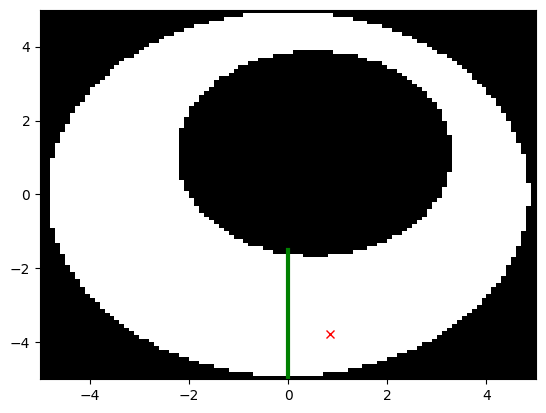

In [13]:
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class=MPPIRacetrack,
    seed: int = 0,
    num_laps: int = 3
) -> int:
    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps

    # Create an instance of your planner
    planner = planner_class(static_map=env.unwrapped)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")

    # Run the environment for num_timesteps, unless the robot hits an obstacle
    # or successfully completes the number of laps needed
    num_timesteps = 500
    success = False
    trajectory = []
    for t in range(num_timesteps):
        action, all_rollouts, best_rollout = planner.get_action(obs)
        obs, _, terminated, _, _ = env.step(action)

        trajectory.append(obs[:2])

        ax.plot(obs[0], obs[1], "bx")

        if terminated:
            success = True
            break

    num_timesteps_used = t

    # Plot the trajectory
    plt.figure()
    plt.title("Robot Trajectory")
    plt.plot(env.unwrapped.finish_line[:, 0], env.unwrapped.finish_line[:, 1], "g", lw=3, label="Finish Line")
    for rollout in all_rollouts:
        plt.plot([x[0] for x in rollout], [x[1] for x in rollout], "b", alpha=0.1)
    plt.plot([x[0] for x in best_rollout], [x[1] for x in best_rollout], "r", label="Best Rollout")
    plt.scatter([x[0] for x in trajectory], [x[1] for x in trajectory], c=range(len(trajectory)), cmap="viridis", label="Path")
    plt.colorbar(label="Time")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1

seed = 0
num_laps = 3
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=MPPIRacetrack, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")


## [Extra Credit] 1c) Compete for the fastest lap time

In this part, you can earn extra credit by achieving faster lap times (measured in average number of steps to complete the course, not computational runtime). You can get some extra credit by implementing a working version of something interesting here (e.g., another planning algorithm, a learning-based method, an extension beyond the basic MPPI we discussed in class). We will give additional extra credit to the student with the fastest lap time, which can be monitored on the Gradescope leaderboard.

In [13]:
class BetterPlanner:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        num_rollouts=100,
        horizon=10,
        lambda_=1.0,
        sigma=0.1,
        control_limits=(-1.0, 1.0)
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.num_rollouts = num_rollouts
        self.horizon = horizon
        self.lambda_ = lambda_
        self.sigma = sigma
        self.control_limits = control_limits

    def get_action(self, obs: np.ndarray) -> np.ndarray:
        best_action = np.zeros_like(self.motion_model.action_space.sample())
        best_score = float('-inf')
        best_rollout = []

        # Initialize list to store all rollouts for plotting
        all_rollouts = []

        # Generate control sequences and simulate rollouts
        for _ in range(self.num_rollouts):
            action = self.motion_model.action_space.sample()  # Sample initial action
            rollout = []  # List to store trajectory for this rollout
            state = initial_state.copy()  # Initialize state

            # Simulate trajectory for the fixed horizon
            for _ in range(self.horizon):
                action += np.random.normal(0, self.sigma, action.shape)  # Add noise to action
                action = np.clip(action, self.control_limits[0], self.control_limits[1])  # Ensure action within limits
                state = self.motion_model.step(state, action)  # Simulate motion model
                rollout.append(state[:2])  # Store (x, y) coordinates

            # Store rollout for plotting
            all_rollouts.append(rollout)

            # Evaluate trajectory and calculate score
            final_position = np.array(rollout[-1])  # Final position of the trajectory
            distance_to_goal = np.linalg.norm(final_position - self.static_map.finish_line[0])  # Calculate distance to finish line
            score = -distance_to_goal  # Negative distance as lower distance is better

            # Update best action and score if this rollout has a better score
            if score > best_score:
                best_score = score
                best_action = action
                best_rollout = rollout

        return best_action, all_rollouts, best_rollout


In [ ]:
seed = 0
num_laps = 3
planner_class = BetterPlanner
run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)

# Problem 2: Trajectory Optimization with `cvxpy`

## 2a) Double Integrator: Initial & Terminal Conditions

For this problem, you'll use the 2D discrete-time double integrator dynamics, where $$\mathbf{x}[t] = \begin{bmatrix}
x[t]\\
y[t]\\
v_x[t]\\
v_y[t]\\
\end{bmatrix}, \quad \mathbf{u}[t] = \begin{bmatrix} a_x[t]\\ a_y[t]\\ \end{bmatrix}, \quad \mathbf{x}[t+dt] = A \mathbf{x}[t] +  B \mathbf{u}[t], \quad A = \begin{bmatrix}
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \quad B = \begin{bmatrix}
\frac{dt^2}{2} & 0 \\
0 & \frac{dt^2}{2} \\
dt & 0 \\
0 & dt \\
\end{bmatrix}.
$$

You should turn the following optimization problem into code:

$$
\begin{align}
\min_{x_{0:T}, u_{0:T}}\quad & (x[T] - g_x)^2 + (y[T] - g_y)^2 \\
\text{s.t.}\quad & \mathbf{x}[t+1] = A \mathbf{x}[t] + B \mathbf{u}[t] \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{u}[t] \in U \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{x}[0] = \mathbf{x}_0 \\
& v_x[T] = v_{x,T} \\
& v_x[T] = v_{y,T} \\
\end{align}
$$

with $g_x = 3, g_y=5, v_{x,T}=0, v_{y,T}=0, \mathbf{x}_0 = [1, 2, 0, 0], U = [-1, 1] \times [-1, 1], T=10$.

**Deliverables**:
- Implement `optimize_trajectory`, which will take in initial and terminal conditions, control limits, dt, and return the optimal sequence of states (i.e., an array of shape (T+1, 4) -- T+1 timesteps (T timesteps + the initial state) and 4 states per timestep)
- Generate a plot of your optimal trajectory. You are welcome to use the `plot_trajectory` function or write your own version.

In [ ]:
def optimize_trajectory(initial_pos, initial_vel, goal_pos, goal_vel, u_limits, dt, T=10):
    """
    Optimizes the trajectory for a double integrator model.

    Args:
    initial_pos (np.ndarray): Initial position [x, y].
    initial_vel (np.ndarray): Initial velocity [vx, vy].
    goal_pos (np.ndarray): Target position [g_x, g_y].
    goal_vel (np.ndarray): Target velocity [v_xT, v_yT].
    u_limits (np.ndarray): Control input limits [[min, max], [min, max]].
    dt (float): Time step.
    T (int): Total number of time steps.

    Returns:
    np.ndarray: The optimal sequence of states (shape (T+1, 4)).
    """

    # Define the state and control variables
    x = cp.Variable((T+1, 4))  # State variable [x, y, vx, vy] for each time step
    u = cp.Variable((T, 2))    # Control variable [ux, uy] for each time step


    """ Example values for u:
    ux    uy
 [[-0.5  0.8] 
 [ 0.2 -0.4]
 [ 0.   0. ]
 [ 0.6  0.2]
 [-1.   0.5]]

 Example values for x:
   x   y   vx  vy
 [[1.  2.  0.  0. ]
 [1.5 2.4 0.  0. ]
 [2.1 3.1 0.5 0.8]
 [3.  4.  1.2 1.2]
 [4.1 5.3 2.1 1.8]
 [5.4 6.9 2.8 2.4]] 
 
u_example represents the control inputs [ux, uy] at each time step.
x_example represents the states [x, y, vx, vy] at each time step, including the initial state at time step 0 and the final state at time step 5.

uy: Control input representing the acceleration in the y-direction.
x: Position in the x-direction.
y: Position in the y-direction.
vx: Velocity in the x-direction.
vy: Velocity in the y-direction
 """


    # Dynamics (Double Integrator Model)
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    B = np.array([[0.5*dt**2, 0],
                  [0, 0.5*dt**2],
                  [dt, 0],
                  [0, dt]])

    # Constraints
    constraints = [x[0] == np.concatenate((initial_pos, initial_vel))]  # Initial condition
    constraints += [x[T, 2:] == goal_vel]  # Final velocity condition
    for t in range(T):
        constraints += [x[t+1] == A @ x[t] + B @ u[t]]  # Dynamics constraint
        constraints += [u[t] >= u_limits[:, 0], u[t] <= u_limits[:, 1]]  # Control input constraints

    # Objective
    objective = cp.Minimize(cp.sum_squares(x[T, :2] - goal_pos))  # Minimize the squared distance from the final position to the goal

    # Define and solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return x.value

def plot_trajectory(xt):
    """
    Plots the trajectory of the double integrator model.

    Args:
    xt (np.ndarray): State trajectory array of shape (T+1, 4).
    """
    plt.plot(xt[:, 0], xt[:, 1], "-x")
    plt.title("Optimal Trajectory")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.axis("equal")
    plt.show()


You can check whether your code works using

In [ ]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

optimal_xt = optimize_trajectory(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
)

plot_trajectory(optimal_xt)

## [Extra Credit] 2b) Incorporate obstacle avoidance as a convex optimization problem

Now, you should extend your optimization code to handle a list of circular obstacles that the double integrator must avoid. We would like you to try to keep this as a convex optimization problem. If you just start adding constraints and costs, you will likely end up with a non-convex optimization problem, which are generally hard to solve.

One possible way to keep the problem convex could be to break the free (i.e., non-obstacle) space into a set of convex regions, then split the trajectory into multiple segments (each one needing to stay within one convex region). But, there could be many other ways, and you are encouraged to try different strategies!


In [ ]:
def optimize_trajectory_with_obstacles(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    obstacles: list,
) -> np.ndarray:

    """ Your implementation here"""
    raise NotImplementedError
    return states


def plot_trajectory_with_obstacles(
    xt: np.ndarray,
    obstacles: list[np.ndarray],
) -> None:

    # Feel free to add to this

    fig, ax = plt.subplots()
    plt.plot(xt[:, 0], xt[:, 1], "-x")
    for obstacle in obstacles:
        ax.add_patch(plt.Circle(obstacle[0:2], obstacle[2], color="r"))
    plt.axis("equal")
    plt.show()

In [ ]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

obstacles = [
    (1.5, 2.5, 0.5),
    (2.0, 3.5, 0.25),
    (2.5, 4.0, 0.5),
]

optimal_xt = optimize_trajectory_with_obstacles(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
    obstacles,
)

plot_trajectory_with_obstacles(optimal_xt, obstacles)